## CSV格式的dataloader

In [1]:
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader, Dataset,RandomSampler,SequentialSampler

### 单类别

### csv 的格式

![](./img/1.png)

In [2]:
'''
csv 数据读取器
'''
class CSVDataset(Dataset):
    # 初始化函数 获取图像路径，标签路径，
    def __init__(self, csv, img_root, image_ids, transforms=None, test=False):
        '''
        csv_path: 训练集或测试集全路径
        image_ids: 真正参与训练或测试的图像，往往用于交叉验证等
        transforms: 图像的增广函数集合
        '''
        # 图片的标签和基本信息
        self._csv = csv
        # 图像路径
        self._img_root = img_root
        # 图片的 ID 列表
        self._image_ids = image_ids
        # 图像增强
        self._transforms = transforms
        # 测试集
        self._test = test

    # 基于 index 获取图像以及标签
    def __getitem__(self, index):
        image_id = self._image_ids[index]
        
        # get image and normalize
        image_path = self._img_root + '/' + image_id + '.jpg'
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # 从csv 读取标签信息
        records = self._csv[self._csv['image_id'] == image_id]
        # 获取 bbox
        boxes = records[['x', 'y', 'w', 'h']].values

        # 转换成模型输入需要的格式 [x0,y0,w,h] -> [x0,y0,x1,y1]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        # 这里只有一类的目标定位问题，标签数量就是 bbox 的数量
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
         # 多做几次图像增强，防止有图像增强失败，如果成功，则直接返回。
        if self._transforms:
            for i in range(10):
                sample = self._transforms(**{
                    'image': image,
                    'bboxes': boxes,
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    boxes = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    boxes[:, [0, 1, 2, 3]] = boxes[:, [1, 0, 3, 2]]  # yxyx: be warning
                    break
        
        return image, boxes, labels, image_id

### example

In [3]:
import pandas as pd

In [4]:
csv = pd.read_csv('D:/Dataset/wheat_detection/train.csv')
csv.head(5)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [5]:
# bbox 字符串转 ndarray
bboxs = np.stack(csv['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    csv[column] = bboxs[:,i]
csv.drop(columns=['bbox'], inplace=True)
csv.head(2)

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0


### 交叉验证

In [6]:
from sklearn.model_selection import StratifiedKFold

In [7]:
# 利用 sklearn 生成 5 折的分层交叉验证的实例。
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### csv 中存在多个图像id相同的合并

In [8]:
# 复制 image_id 
df_folds = csv[['image_id']].copy()

In [9]:
df_folds.head(3)

,image_id
0,b6ab77fd7
1,b6ab77fd7
2,b6ab77fd7


In [10]:
# 设定每一个 image_id 的 bbox个数（这个时候image_id 是有重复的）
df_folds.loc[:, 'bbox_count'] = 1
df_folds.head(3)

,image_id,bbox_count
0,b6ab77fd7,1
1,b6ab77fd7,1
2,b6ab77fd7,1


In [11]:
# 按照 image_id 聚合，得到每一个 image_id 的 bbox 的个数
df_folds = df_folds.groupby('image_id').count()
df_folds.head(3)

,bbox_count
image_id,
00333207f,55
005b0d8bb,20
006a994f7,25


In [12]:
# 取 source
df_folds.loc[:, 'source'] = csv[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.head(3)

,bbox_count,source
image_id,,
00333207f,55,arvalis_1
005b0d8bb,20,usask_1
006a994f7,25,inrae_1


In [13]:
# 按照 source 和 bbox_count 的个数划分为了 34 个 group  
# 这么做的目的来源于两个方面。
# 1. 需要保证划分的多折训练集中数据来源占比一致。
# 2. 需要保证划分的多折训练集中 bbox 分布大致一致。 
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.head(3)

,bbox_count,source,stratify_group
image_id,,,
00333207f,55,arvalis_1,arvalis_1_3
005b0d8bb,20,usask_1,usask_1_1
006a994f7,25,inrae_1,inrae_1_1


In [14]:
# 设定默认的 fold 为 0 
df_folds.loc[:, 'fold'] = 0

In [15]:
df_folds.index

Index(['00333207f', '005b0d8bb', '006a994f7', '00764ad5d', '00b5fefed',
       '00b70a919', '00e903abe', '00ea5e5ee', '010b216d4', '010c93b99',
       ...
       'ff46aa8d4', 'ff5c9104a', 'ff86547fb', 'ffaa964a2', 'ffb0f6eca',
       'ffb445410', 'ffbf75e5b', 'ffbfe7cc0', 'ffc870198', 'ffdf83e42'],
      dtype='object', name='image_id', length=3373)

In [16]:
# 进行分层的交叉验证，将 ‘stratify_group’ 做为 y。这样就保证了划分的一致性。
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [17]:
df_folds.head(5)

,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3


### transform|

In [18]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [19]:
# 训练集阶段的数据增强变换
# 依托于 albumentations 这个三方包
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit= 0.3,
                                     val_shift_limit=0.3, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.4,
                                           contrast_limit=0.3, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

# 验证集阶段的数据增强变换
# 依托于 albumentations 这个三方包
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [20]:
# 取第 0 折为验证集，其余 4 折为训练集
fold_number = 0

train_dataset = CSVDataset(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    csv=csv,
    img_root='D:/Dataset/wheat_detection/train/',
    transforms=get_train_transforms(),
    test=False,
)

C:\Users\郭闪闪\AppData\Roaming\Python\Python38\site-packages\albumentations\augmentations\transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [22]:
from matplotlib import pyplot as plt

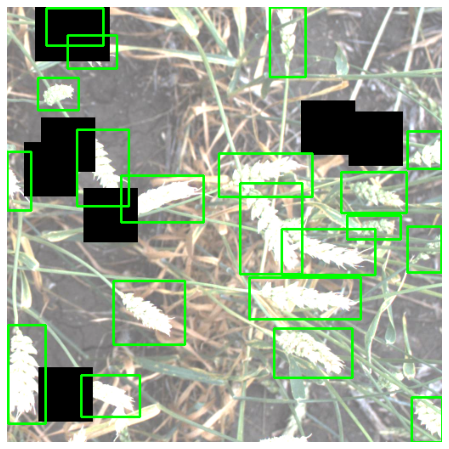

In [23]:
# 验证一下生成器得到的训练数据是否正确
image, boxes, labels, image_id = train_dataset[1]
boxes = boxes.cpu().numpy().astype(np.int32)
numpy_image = image.permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8));
for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3], box[2]), (0, 1, 0), 2);
ax.set_axis_off()
ax.imshow(numpy_image)